IN THIS DOCUMENT...

I will test the preprocessing and visualize the data that we are working with. It is meant a support document to utilize if we want to quickly check the data preprocessing and final database

First... Import statements!

In [1]:
import os
import pandas as pd
import numpy as np
import json
import plotly.express as px
import plotly.graph_objects as go
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
import shap
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer



C:\Users\emmxc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For the unofficial database that we have from Kaggle there is already some preprocessing developed so we will use it for a first preprocessing before harmonization and differentiation.

This data comes from three sources:

- Reader_data: Glucose extracts for each week for one user. Contains: Historic Glucose, Scan Glucose, Record Type, Time, ID, Non-nummeric Rapid-Acting Insulin, Rapid-Active Insulin, Non-numeric Food, Carbohydrates, Non-numeric Long-Acting Insulin, Long-Acting Insulin,Note, Strip Glucose, Ketone, Meal Insulin, Correction Insulin, User change Insulin, Previous Time and Updated Time.

But I am only interested in extracting: Time, Historic Glucose, Rapid-Acting Insulin and Long-Acting Insulin.

Since the Scan Glucose has a lot of missing values and Historic Glucose has exactly one record for each 15 minutes intervals (not necessarily taken every 15 minutes but somewhere in the 15 minutes window) I believe it is better to focus on the Historic Glucose Data.

- MySugr_data: It is the data about the meals of the user and contains: Date, Time, Tags, Blood Sugar Measurement, Insulin Injection Units, Basal Injection Units, Insulin Injection Units pump, Insulin of meal, Insulin correction, Temproal Basal Percentage, Temporal basal duration, Meal Carbohydrates, Meal description, Activity Duration, Activity Intensity, Activity description, Steps, Note, Location, Blood Pressure, Body weight, HbA1c, Ketones, Food type and medication.

I am only going to extract: Time and Meal carbohydrates

- fitbit_data: Data from a fitbit band monitoring it contains personal account, physical activity, sleep and stress. I will personally focus first on extracting physical activity and stress.

From these I will use the values of: Time, BPM, total_minutes, distance and calories. And from stress just the subjective stress score as indicated by the user.



In [2]:

# Initialize df_combined outside of the functions
df_combined = pd.DataFrame()

def load_reader_dataset():
    # Specify the path for reader data
    reader_data = "C:/Users/emmxc/OneDrive/Escritorio/FinalProjectThesis/data/reader_data"
    exports = [os.path.join(reader_data, export) for export in os.listdir(reader_data)]
    exports.sort(reverse=False)

    df = pd.read_csv(exports[0], sep="\t")
    for export in exports[1:]:
        df = pd.concat([df, pd.read_csv(export, sep="\t")])

    # Exports usually overlap, so drop the duplicates
    df.drop_duplicates(inplace=True)

    # Dropping columns that are not needed
    df.drop(['Non-numeric Food', 'Non-numeric Long-Acting Insulin','Strip Glucose (mmol/L)','Scan Glucose (mmol/L)','Previous Time', 'Updated Time', 'Non-numeric Rapid-Acting Insulin',
             'Notes', 'Ketone (mmol/L)', 'User Change Insulin (units)', 'Record Type','Correction Insulin (units)','Carbohydrates (grams)', 'ID', 'Meal Insulin (units)'],
            axis=1, inplace=True)

    df.rename(columns={'Rapid-Acting Insulin (units)': 'Rapid Insulin',
                       'Long-Acting Insulin (units)': 'Long Insulin'},
              inplace=True)

    df['Time'] = pd.to_datetime(df['Time'], format="%Y/%m/%d %H:%M")
    df.sort_values(by='Time', inplace=True)

    # Only considering Historical Glucose (reliable 15min measurements) - we're not using Scan Glucose column
    df.rename(columns={'Historic Glucose (mmol/L)': 'Glucose'}, inplace=True)

    # Since 2022/01/09 00:00 we use mySugr to keep track of insulin and Carbohydrates, so drop any data after this date
    df.loc[df['Time'] >= "2022/01/09 00:00", ['Rapid Insulin', 'Long Insulin']] = np.nan

    global df_combined
    df_combined = pd.concat([df_combined, df], ignore_index=True)
    return df


def load_mySugr_dataset():
    mySugr_data = "C:/Users/emmxc/OneDrive/Escritorio/FinalProjectThesis/data/mySugr_data/2022_01_09-2022_04_25_export.csv"
    mysugr_df = pd.read_csv(mySugr_data, sep=",")

    # Keeping only the relevant columns
    mysugr_df = mysugr_df[['Date', 'Time', 'Meal Carbohydrates (Grams, Factor 1)']]

    mysugr_df.rename(columns={'Meal Carbohydrates (Grams, Factor 1)': 'Carbohydrates'}, inplace=True)

    mysugr_df["Time"] = pd.to_datetime(mysugr_df["Date"] + " " + mysugr_df["Time"], format="%b %d, %Y %I:%M:%S %p")
    mysugr_df.sort_values(by='Time', inplace=True)
    mysugr_df.drop(['Date'], axis=1, inplace=True)

    global df_combined
    df_combined = pd.concat([df_combined, mysugr_df], ignore_index=True)
    return mysugr_df


def read_fitbit_json_export(export_file, export_type):
    with open(export_file, "r") as f:
        j = json.load(f)
    df_read = pd.json_normalize(j)
    df_read["dateTime"] = pd.to_datetime(df_read["dateTime"], format="%m/%d/%y %H:%M:%S")

    if export_type == "heart":
        df_read.rename(columns={"value.bpm": "bpm"}, inplace=True)
        df_read.drop("value.confidence", axis=1, inplace=True)
    elif export_type == "calories":
        df_read.rename(columns={"value": "calories"}, inplace=True)
        df_read["calories"] = df_read["calories"].astype(float)
    elif export_type == "distance":
        df_read.rename(columns={"value": "distance"}, inplace=True)
        df_read["distance"] = df_read["distance"].astype(int)
        # Convert from centimeters to meters
        df_read["distance"] = df_read["distance"] / 100
    else:
        raise Exception("Export type not recognized")
    
    return df_read


def load_fitbit_dataset():
    fitbit_data = "C:/Users/emmxc/OneDrive/Escritorio/FinalProjectThesis/data/fitbit_data/2022_04_25_all_time_export/Physical Activity"

    calories_exports = sorted([os.path.join(fitbit_data, export) for export in os.listdir(fitbit_data) if "calories" in export])
    distance_exports = sorted([os.path.join(fitbit_data, export) for export in os.listdir(fitbit_data) if "distance" in export])
    heart_rate_exports = sorted([os.path.join(fitbit_data, export) for export in os.listdir(fitbit_data) if "heart_rate-" in export and not "resting" in export])

    df_fitbit = read_fitbit_json_export(calories_exports[0], "calories")
    for export in calories_exports[1:]:
        df_fitbit = pd.concat([df_fitbit, read_fitbit_json_export(export, "calories")], ignore_index=True)
    for export in distance_exports:
        df_fitbit = pd.concat([df_fitbit, read_fitbit_json_export(export, "distance")], ignore_index=True)
    for export in heart_rate_exports:
        df_fitbit = pd.concat([df_fitbit, read_fitbit_json_export(export, "heart")], ignore_index=True)

    # Change to 1 minute frequency
    df_fitbit = df_fitbit.set_index('dateTime').resample('1T').agg(
        {'bpm': pd.Series.mean, 'distance': pd.Series.sum, 'calories': pd.Series.sum}).reset_index()

    df_fitbit.rename(columns={"dateTime": "Time"}, inplace=True)
    df_fitbit.sort_values(by='Time', inplace=True)

    global df_combined
    df_combined = pd.concat([df_combined, df_fitbit], ignore_index=True)
    return df_fitbit


def load_stressdata():
    stress_data = "C:/Users/emmxc/OneDrive/Escritorio/FinalProjectThesis/data/fitbit_data/2022_04_25_all_time_export/Stress/Stress Score.csv"
    stress_df = pd.read_csv(stress_data, sep=",")
    stress_df = stress_df[['UPDATED_AT', 'STRESS_SCORE']]

    stress_df.rename(columns={'STRESS_SCORE': 'Stress'}, inplace=True)

    stress_df['Time'] = stress_df['UPDATED_AT'].str.replace('T', ' ')
    stress_df['Time'] = pd.to_datetime(stress_df['Time'], format='%Y-%m-%d %H:%M:%S.%f')

    stress_df.drop(['UPDATED_AT'], axis=1, inplace=True)
    stress_df.sort_values(by='Time', inplace=True)

    global df_combined
    df_combined = pd.concat([df_combined, stress_df], ignore_index=True)
    return stress_df


# Now you can call these functions to load and combine the data
load_reader_dataset()
load_mySugr_dataset()
load_fitbit_dataset()
load_stressdata()

# After calling these methods, df_combined will have all the datasets combined in one DataFrame.
print(df_combined)


                          Time  Glucose  Rapid Insulin  Long Insulin  \
0      2020-11-02 18:09:00.000      7.8            NaN           NaN   
1      2020-11-02 18:24:00.000      8.0            NaN           NaN   
2      2020-11-02 18:38:00.000      7.6            NaN           NaN   
3      2020-11-02 18:53:00.000      7.3            NaN           NaN   
4      2020-11-02 19:08:00.000      7.3            NaN           NaN   
...                        ...      ...            ...           ...   
266051 2022-04-21 09:58:44.073      NaN            NaN           NaN   
266052 2022-04-22 21:57:22.002      NaN            NaN           NaN   
266053 2022-04-23 10:25:39.922      NaN            NaN           NaN   
266054 2022-04-24 12:50:45.757      NaN            NaN           NaN   
266055 2022-04-25 07:34:26.828      NaN            NaN           NaN   

        Carbohydrates  bpm  distance  calories  Stress  
0                 NaN  NaN       NaN       NaN     NaN  
1                 NaN

In [3]:
df_combined.to_csv('preprocessing.csv',sep='\t', index=False )

After the Preprocessing the data looks as shown in the csv file called 'preprocessing.csv'...

There are 166067 rows indexed by time

There are 9 columns: Time, Glucose, Carbohydrates, Rapid Insulin, Long Insulin, bpm, distance, calories and Stress


*HARMONIZING*

Since the data is not collected at the same time moments and we want to do time series analysis we need to harmonize it. Since the most consistent data is the historic glucose and there is a value each 15 minutes, I will harmonize for 15 minute intervals.

HARMONIZING STRATEGIES:
-Glucose: There is just one value each 15 minutes since it is the historic glucose, so that is our value!
- Carbodyrates: Sum the carbs eaten in those 15 minutes
- Rapid Insulin: Sum the insulin injected in those 15 minutes
- Long Insulin: Sum the insulin injected in those 15 minutes
- bpm: Average the bpm in those 15 mintues
- distace: sum the distance in those 15 minutes
- calories: Sum the calories used in those 15 minutes
- stress: average the stress score from those registered within the 15 minutes window

In [4]:
temp = df_combined.copy()

start_time = "2020-11-02 18:09:00"  # Change this to your starting point
end_time = temp.index.max()  # Or set your desired end time

time_range = pd.date_range(start=start_time, end=end_time, freq='15T')
temp.set_index('Time', inplace=True)

#  glucose value for each 15-minute period
df_glu = temp.resample('15T')['Glucose'].mean()

#Carbohydrates consumption added each 15 minutes period
df_car = temp.resample('15T')['Carbohydrates'].sum()


#Rapid Insulin added each 15 minutes
df_rap = temp.resample('15T')['Rapid Insulin'].sum()

#Long Insulin added each 15 minutes
df_long = temp.resample('15T')['Long Insulin'].sum()

#BPM
df_bpm = temp.resample('15T')['bpm'].mean()

#calories
df_calories = temp.resample('15T')['calories'].sum()

# Distance 
df_distance = temp.resample('15T')['distance'].sum()

#stress
df_st = temp.resample('15T')['Stress'].sum()

df_har = pd.DataFrame({
    'Time': df_glu.index,
    'Glucose': df_glu,
    'Carbohydrates': df_car,
    'Rapid Insulin': df_rap,
    'Long Insulin': df_long,
    'BPM': df_bpm,
    'Calories': df_calories,
    'Distance': df_distance,
    'Stress': df_st
})


# Save the resulting data to a CSV file
df_har.to_csv( 'harmonized_data.csv', sep='\t', index=False)

Let's do some quick visualization with matplotlib

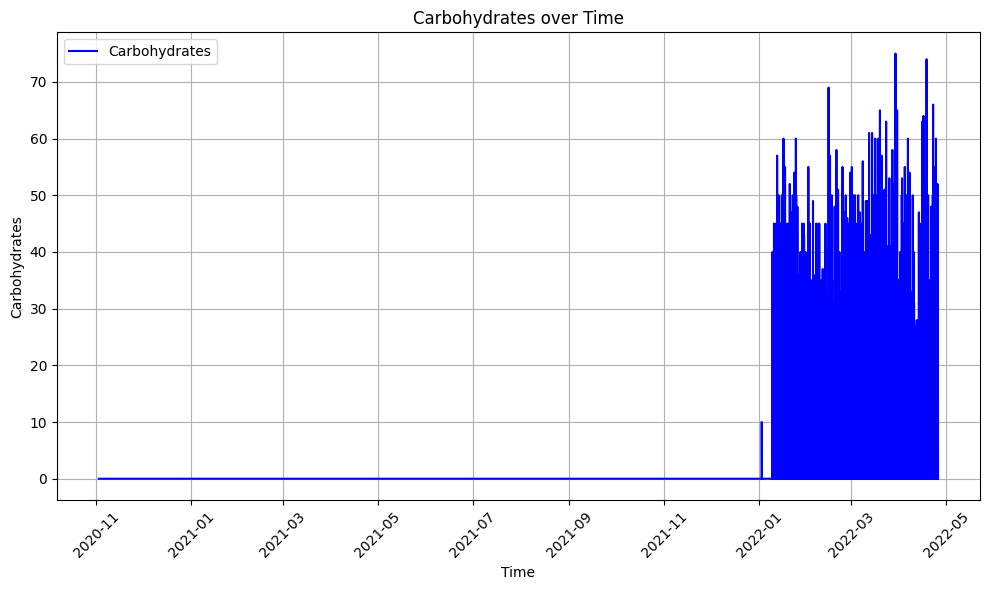

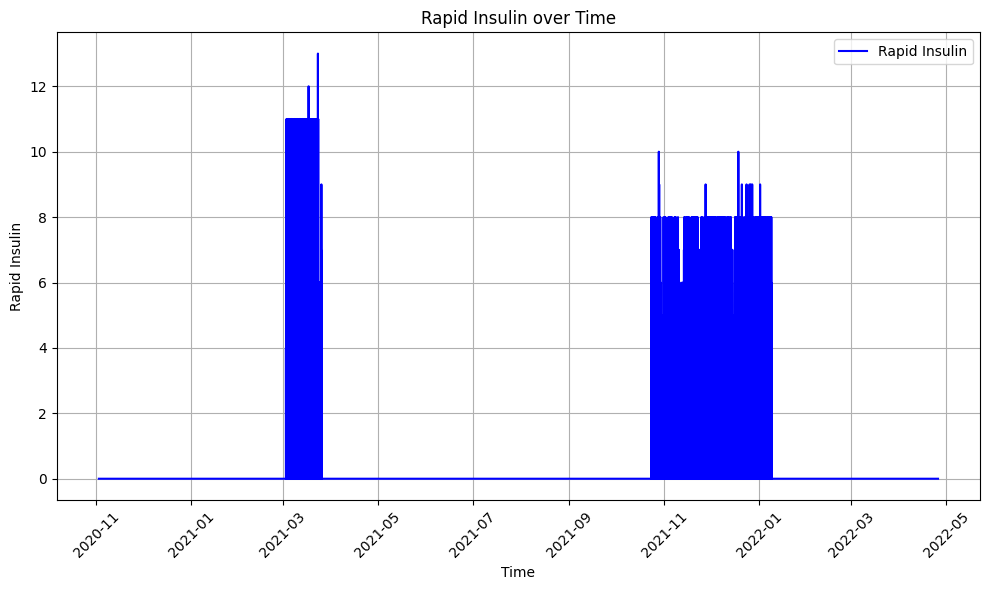

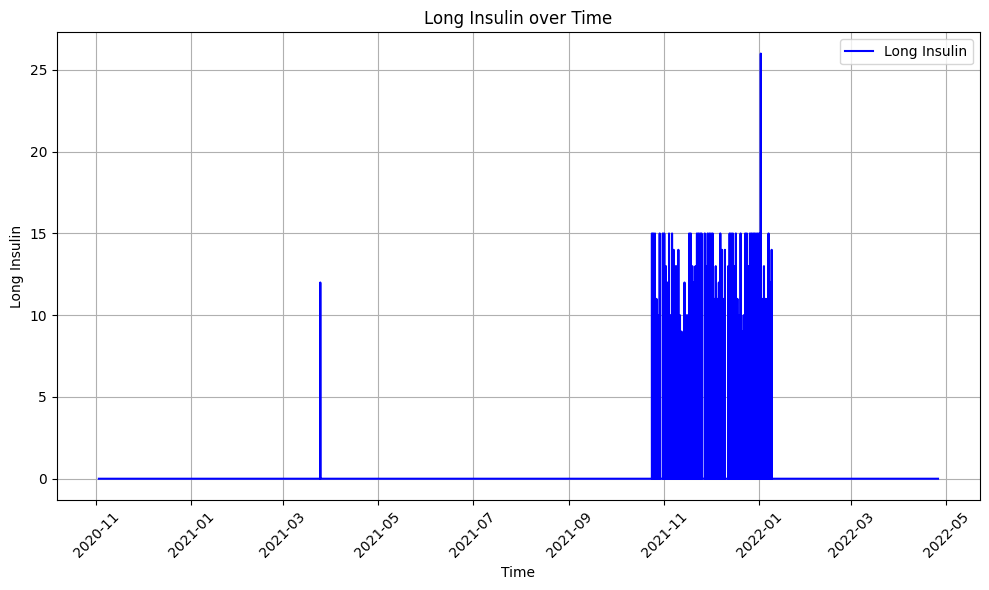

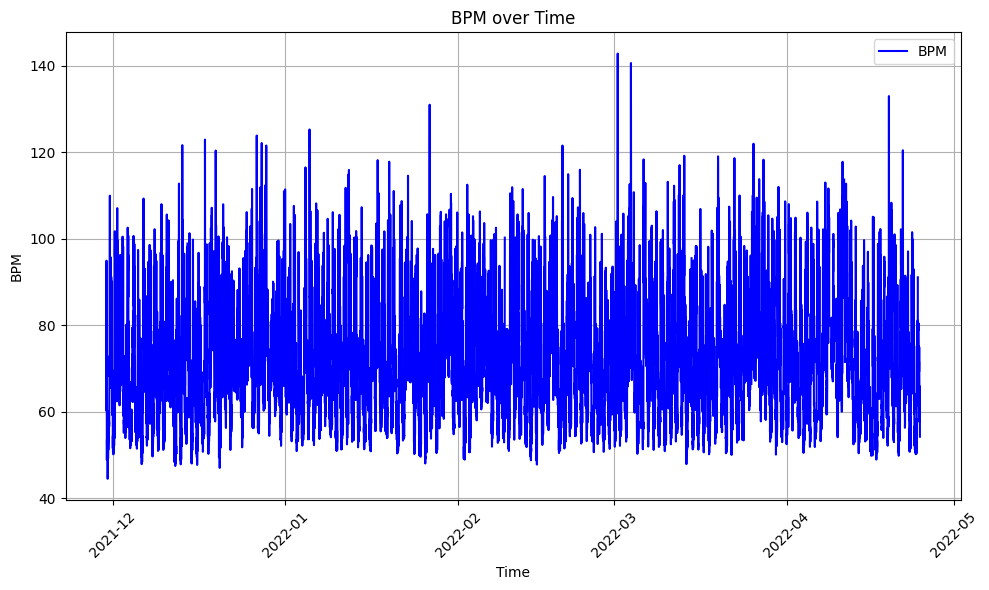

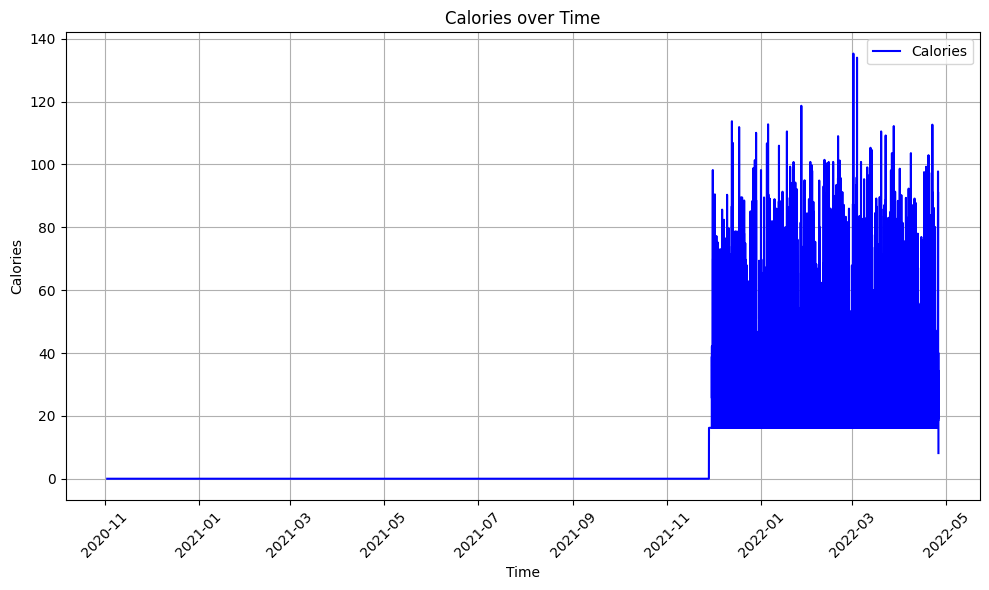

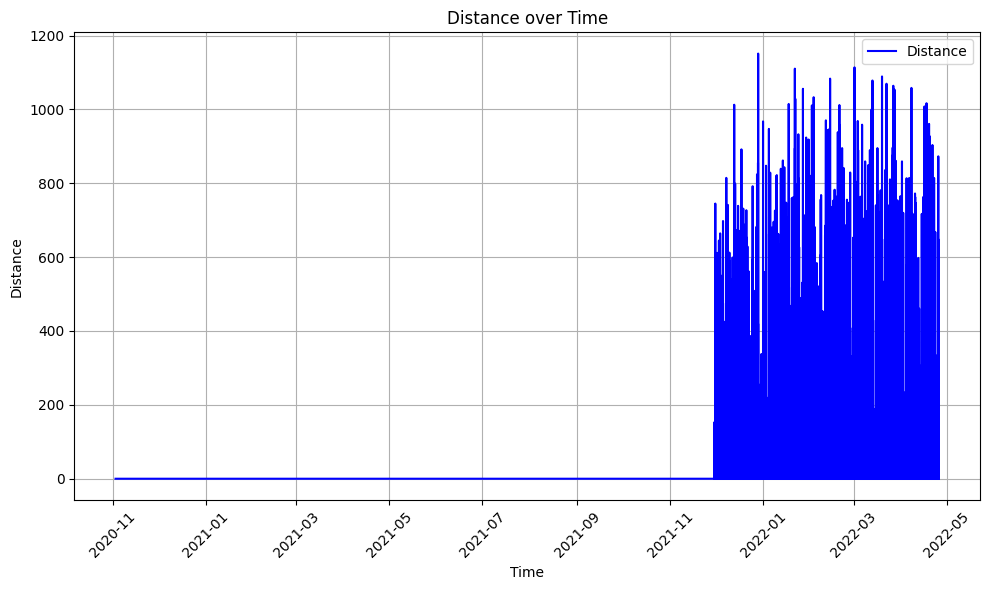

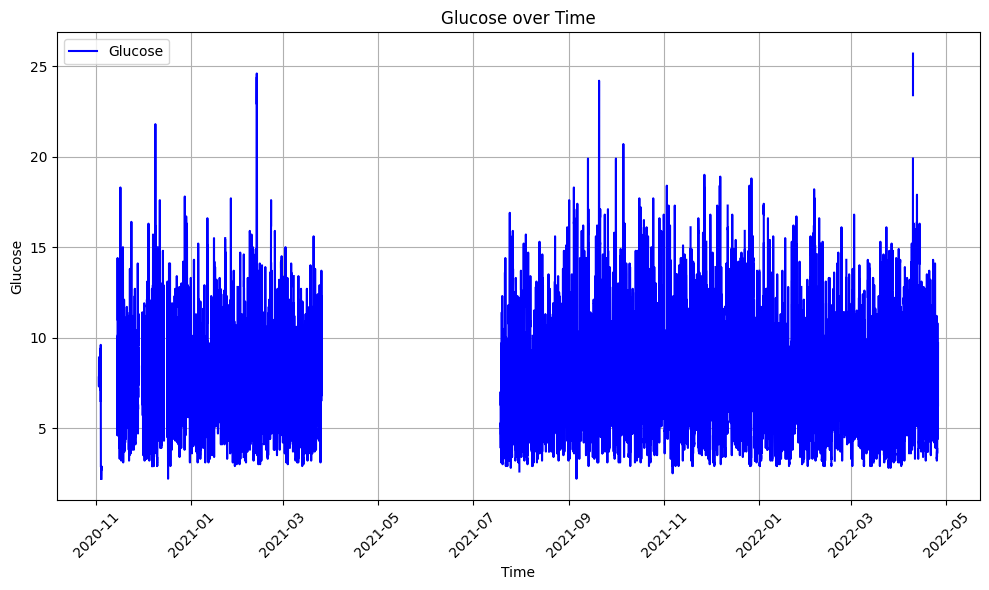

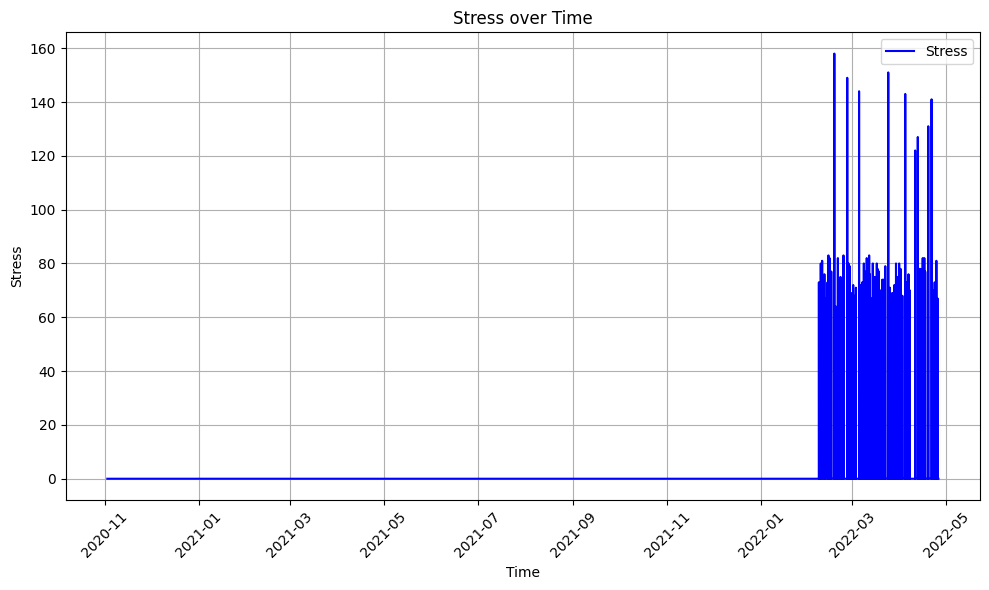

In [5]:

# Define the columns you want to plot
columns_to_plot = ['Carbohydrates', 'Rapid Insulin', 'Long Insulin', 'BPM', 'Calories', 'Distance', 'Glucose', 'Stress']

# Create a plot for each column
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))  # Adjust the figure size as necessary
    plt.plot(df_har['Time'], df_har[column], label=column, color='b')  # Plot the data
    plt.title(f'{column} over Time')
    plt.xlabel('Time')
    plt.ylabel(column)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Now we do the kinetics for insulin and carbohydrates and save it in kinetics csv file and the final dataframe called DF.

In [6]:
# Create a copy of df_har for the kinetics DataFrame
df_kinetics = df_har.copy()

# Constants for the Kinetics
ka1 = 0.0164  # Absorption rate constant for nonmonomeric insulin (min^-1)
ka2 = 0.0182  # Absorption rate constant for monomeric insulin (min^-1)
kd = 0.0076   # Dissociation rate constant (min^-1)

df_kinetics['Insulin absorption'] = pd.Series(dtype='float')

# Reset index, and set the start of the index to 1 instead of 0
df_kinetics.reset_index(drop=True, inplace=True)
df_kinetics.index += 1  # Add 1 to the index to start from 1


In [7]:
# Constants for the Kinetics
ka1 = 0.0164  # Absorption rate constant for nonmonomeric insulin (min^-1)
ka2 = 0.0182  # Absorption rate constant for monomeric insulin (min^-1)
kd = 0.0076   # Dissociation rate constant (min^-1)

# Add the column for carbohydrate absorption
df_kinetics['Carbs absorption'] = pd.Series(dtype='float')

# Loop to iterate through df_kinetics and calculate insulin absorption and carbohydrate absorption
for i in range(1, len(df_kinetics)):
    # Initialize insulin concentrations for this interval
    I_scl1 = 0.25  # Initial nonmonomeric insulin concentration (subcutaneous space)
    I_scl2 = 0.25  # Initial monomeric insulin concentration (subcutaneous space)
    I_scs = 0.25   # Initial insulin concentration in the bloodstream
    
    # Initialize carbohydrate concentrations for this interval
    C_scl1 = 0.25  # Initial nonmonomeric carbohydrate concentration (subcutaneous space)
    C_scl2 = 0.25  # Initial monomeric carbohydrate concentration (subcutaneous space)
    C_scs = 0.25   # Initial carbohydrate concentration in the bloodstream

    # For rapid insulin injection
    if df_kinetics.at[i, 'Rapid Insulin'] > 0:
        u = df_kinetics.at[i, 'Rapid Insulin']  # Total infusion rate for rapid insulin

        # Loop through the current and following intervals (30 or 50 intervals)
        for j in range(i, min(i + 50, len(df_kinetics))):
            # Calculate the time difference in minutes as an integer
            t = (df_kinetics.iloc[j]['Time'] - df_kinetics.iloc[i]['Time']).total_seconds() // 60  # Convert to minutes
            
            # Apply the compartment model for rapid insulin
            I_scl1 = I_scl1 + (- (ka1 + ka1) * I_scl1) + u * 15  # Time step = 15 minutes
            I_scl2 = I_scl2 + (ka1 * I_scl1 - ka2 * I_scl2) * 15
            I_scs = I_scs + (ka2 * I_scl2 - kd * I_scs) * 15

            # Compute the insulin absorption (Ri) for this period
            insulin_absorbed = ka1 * I_scl1 - ka2 * I_scl2

            # Store the absorption value for this time step
            df_kinetics.at[j, 'Insulin absorption'] = insulin_absorbed

            # If absorption becomes negligible, break the loop
            if I_scs < 0.1:  # Set threshold for negligible absorption
                break

    # For long insulin injection
    if df_kinetics.at[i, 'Long Insulin'] > 0:
        u = df_kinetics.at[i, 'Long Insulin']  # Total infusion rate for long insulin

        # Loop through the current and following intervals (30 or 50 intervals)
        for j in range(i, min(i + 50, len(df_kinetics))):
            # Calculate the time difference in minutes as an integer
            t = (df_kinetics.iloc[j]['Time'] - df_kinetics.iloc[i]['Time']).total_seconds() // 60  # Convert to minutes
            
            # Apply the compartment model for long insulin
            I_scl1 = I_scl1 + (- (ka1 + ka1) * I_scl1) + u   # Time step = 15 minutes
            I_scl2 = I_scl2 + (ka1 * I_scl1 - ka2 * I_scl2) 
            I_scs = I_scs + (ka2 * I_scl2 - kd * I_scs) 

            # Compute the insulin absorption (Ri) for this period
            insulin_absorbed = ka1 * I_scl1 - ka2 * I_scl2

            # Store the absorption value for this time step
            df_kinetics.at[j, 'Insulin absorption'] = insulin_absorbed

            # If absorption becomes negligible, break the loop
            if I_scs < 0.1:  # Set threshold for negligible absorption
                break

    # For carbohydrate absorption (similar to insulin)
    if df_kinetics.at[i, 'Carbohydrates'] > 0:
        u_carbs = df_kinetics.at[i, 'Carbohydrates']  # Total carbohydrate intake for this time step

        # Loop through the current and following intervals for carbohydrates (30 or 50 intervals)
        for j in range(i, min(i + 50, len(df_kinetics))):
            # Calculate the time difference in minutes as an integer
            t = (df_kinetics.iloc[j]['Time'] - df_kinetics.iloc[i]['Time']).total_seconds() // 60  # Convert to minutes
            
            # Apply the compartment model for carbohydrates (similar to insulin model)
            C_scl1 = C_scl1 + (- (ka1 + ka1) * C_scl1) + u * 15  # Time step = 15 minutes
            C_scl2 = C_scl2 + (ka1 * C_scl1 - ka2 * C_scl2) * 15
            C_scs = C_scs + (ka2 * C_scl2 - kd * C_scs) * 15

            # Compute the carbohydrate absorption (Ri) for this period
            carbs_absorbed = ka1 * C_scl1 - ka2 * C_scl2

            # Store the carbohydrate absorption value for this time step
            df_kinetics.at[j, 'Carbs absorption'] = carbs_absorbed

            # If absorption becomes negligible, break the loop
            if C_scs < 0.1:  # Set threshold for negligible absorption
                break

# Debugging: Check the DataFrame before saving to CSV
print(df_kinetics.tail())  # Make sure 'Insulin absorption' and 'Carbs absorption' are correctly calculated

# Save the resulting data to a CSV file
df_kinetics.to_csv('insulin_carbs_absorption.csv', sep='\t', index=False)


                     Time  Glucose  Carbohydrates  Rapid Insulin  \
51753 2022-04-25 20:00:00      6.2            0.0            0.0   
51754 2022-04-25 20:15:00      7.3            0.0            0.0   
51755 2022-04-25 20:30:00      8.9            0.0            0.0   
51756 2022-04-25 20:45:00      9.7            0.0            0.0   
51757 2022-04-25 21:00:00      NaN            0.0            0.0   

       Long Insulin  BPM  Calories  Distance  Stress  Insulin absorption  \
51753           0.0  NaN     19.17       0.0     0.0                 NaN   
51754           0.0  NaN     19.36       0.0     0.0                 NaN   
51755           0.0  NaN     27.03       0.0     0.0                 NaN   
51756           0.0  NaN     27.87       0.0     0.0                 NaN   
51757           0.0  NaN      8.16       0.0     0.0                 NaN   

       Carbs absorption  
51753          4.241514  
51754          5.425723  
51755          6.209820  
51756          6.705556  
5175

Now we will do the regression and classifier, but there is a big problem with the sparsity of the data, however our dataframe has the structure that it should

In [8]:

# Assuming df_kinetics is your final dataframe with the correct features
# First, create the target variables: Hyperglycemia and Hypoglycemia based on Glucose

# Define the glucose thresholds for hyperglycemia and hypoglycemia
hyperglycemia_threshold = 6.9  # mg/dL
hypoglycemia_threshold = 3.9  # mg/dL

# Create two target variables
df_kinetics['Hyperglycemia'] = (df_kinetics['Glucose'] > hyperglycemia_threshold).astype(int)
df_kinetics['Hypoglycemia'] = (df_kinetics['Glucose'] < hypoglycemia_threshold).astype(int)

# Drop the 'Glucose' and 'Time' columns (since they're not used in the classification task)
df_features = df_kinetics.drop(['Glucose', 'Time'], axis=1)

# We will use the remaining columns as features
features = ['Carbohydrates', 'Rapid Insulin', 'Long Insulin', 'BPM', 'Calories', 'Distance', 'Stress', 'Insulin absorption', 'Carbs absorption']

# Extract the features and the target labels for both hyperglycemia and hypoglycemia
X = df_features[features]

# Handling missing values (if any) by using SimpleImputer to fill NaN values with the mean of the column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# For classification, we'll use hyperglycemia as the target variable first
y = df_kinetics['Hyperglycemia']  # You can also use 'Hypoglycemia' here depending on the task

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
model_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_rf.predict(X_test)

# Evaluate the model's performance using classification metrics
print("Classification Report for Hyperglycemia:")
print(classification_report(y_test, y_pred))

# Optionally, if you want to predict for hypoglycemia instead:
y_hypo = df_kinetics['Hypoglycemia']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_hypo, test_size=0.2, random_state=42)

# Train the model again for hypoglycemia
model_rf.fit(X_train, y_train)

# Make predictions on the test set for hypoglycemia
y_pred_hypo = model_rf.predict(X_test)

# Evaluate the model's performance for hypoglycemia
print("Classification Report for Hypoglycemia:")
print(classification_report(y_test, y_pred_hypo))



Classification Report for Hyperglycemia:
              precision    recall  f1-score   support

           0       0.65      0.87      0.75      6037
           1       0.67      0.36      0.46      4315

    accuracy                           0.66     10352
   macro avg       0.66      0.61      0.61     10352
weighted avg       0.66      0.66      0.63     10352

Classification Report for Hypoglycemia:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      9908
           1       0.31      0.05      0.09       444

    accuracy                           0.95     10352
   macro avg       0.63      0.52      0.53     10352
weighted avg       0.93      0.95      0.94     10352



The high recall for class 0 (non-hyperglycemia and non-hypoglycemia) and low recall for class 1 (hyperglycemia and hypoglycemia) suggests that the data may be imbalanced. To improve performance, you may need to address the imbalance using techniques like resampling (oversampling the minority class or undersampling the majority class) or adjusting class weights during model training.